## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
# %load_ext autoreload
# %autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F

def gpu(x):
    return x.cuda() if torch.cuda.is_available() else x

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = gpu(Net())
print(net)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.3)
  (drop4): Dropout(p=0.4)
  (drop5): Dropout(p=0.5)
  (drop6): Dropout(p=0.6)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(135), RandomCrop(128), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 128, 128]) torch.Size([68, 2])
1 torch.Size([1, 128, 128]) torch.Size([68, 2])
2 torch.Size([1, 128, 128]) torch.Size([68, 2])
3 torch.Size([1, 128, 128]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)



In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = gpu(images.type(torch.FloatTensor))

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 128, 128])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

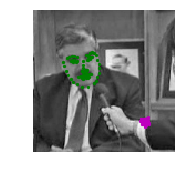

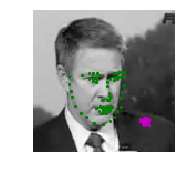

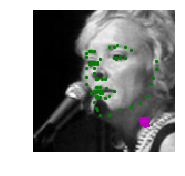

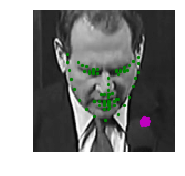

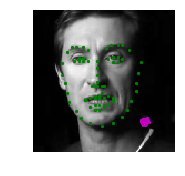

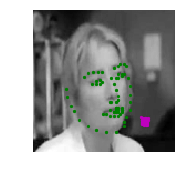

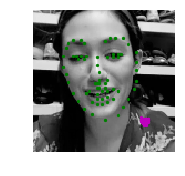

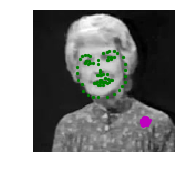

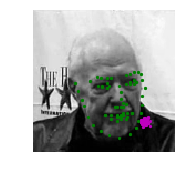

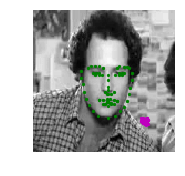

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(30,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.to(torch.device("cpu"))
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.to(torch.device("cpu"))
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = gpu(nn.SmoothL1Loss())

initial_lr=0.1
optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
def train_net(n_epochs):
    # prepare the net for training
    net.train()
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = gpu(key_pts.type(torch.FloatTensor))
            images = gpu(images.type(torch.FloatTensor))

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            
            if batch_i % 10 == 9:    # print every 10 batches
                avg_loss = running_loss/10
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [14]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

training_loss = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.27351622879505155
Epoch: 1, Batch: 20, Avg. Loss: 0.20222387909889222
Epoch: 1, Batch: 30, Avg. Loss: 0.10114720202982426
Epoch: 1, Batch: 40, Avg. Loss: 0.038014357723295686
Epoch: 1, Batch: 50, Avg. Loss: 0.03919925633817911
Epoch: 1, Batch: 60, Avg. Loss: 0.03491780199110508
Epoch: 1, Batch: 70, Avg. Loss: 0.036562537774443626
Epoch: 1, Batch: 80, Avg. Loss: 0.041460470482707026
Epoch: 1, Batch: 90, Avg. Loss: 0.03338009724393487
Epoch: 1, Batch: 100, Avg. Loss: 0.03617708943784237
Epoch: 1, Batch: 110, Avg. Loss: 0.030530293099582197
Epoch: 1, Batch: 120, Avg. Loss: 0.03218865059316158
Epoch: 1, Batch: 130, Avg. Loss: 0.028692070953547956
Epoch: 1, Batch: 140, Avg. Loss: 0.026687614060938357
Epoch: 1, Batch: 150, Avg. Loss: 0.029634387977421284
Epoch: 1, Batch: 160, Avg. Loss: 0.029058734141290187
Epoch: 1, Batch: 170, Avg. Loss: 0.029366119764745235
Epoch: 1, Batch: 180, Avg. Loss: 0.025705930404365064
Epoch: 1, Batch: 190, Avg. Loss: 0.0262133926

Epoch: 5, Batch: 190, Avg. Loss: 0.020207226928323507
Epoch: 5, Batch: 200, Avg. Loss: 0.016809414606541395
Epoch: 5, Batch: 210, Avg. Loss: 0.0189072378911078
Epoch: 5, Batch: 220, Avg. Loss: 0.017488030903041362
Epoch: 5, Batch: 230, Avg. Loss: 0.027147146686911584
Epoch: 5, Batch: 240, Avg. Loss: 0.020831688400357963
Epoch: 5, Batch: 250, Avg. Loss: 0.020235093124210835
Epoch: 5, Batch: 260, Avg. Loss: 0.024581584334373473
Epoch: 5, Batch: 270, Avg. Loss: 0.019528331328183414
Epoch: 5, Batch: 280, Avg. Loss: 0.02069214526563883
Epoch: 5, Batch: 290, Avg. Loss: 0.02265808777883649
Epoch: 5, Batch: 300, Avg. Loss: 0.024428656790405512
Epoch: 5, Batch: 310, Avg. Loss: 0.026566568948328494
Epoch: 5, Batch: 320, Avg. Loss: 0.020686839986592532
Epoch: 5, Batch: 330, Avg. Loss: 0.022212651278823613
Epoch: 5, Batch: 340, Avg. Loss: 0.02008435586467385
Epoch: 6, Batch: 10, Avg. Loss: 0.022122991271317005
Epoch: 6, Batch: 20, Avg. Loss: 0.02537056440487504
Epoch: 6, Batch: 30, Avg. Loss: 0.02

Epoch: 10, Batch: 30, Avg. Loss: 0.01267984015867114
Epoch: 10, Batch: 40, Avg. Loss: 0.01419995240867138
Epoch: 10, Batch: 50, Avg. Loss: 0.013204435259103775
Epoch: 10, Batch: 60, Avg. Loss: 0.013606072589755058
Epoch: 10, Batch: 70, Avg. Loss: 0.015008351719006895
Epoch: 10, Batch: 80, Avg. Loss: 0.011408118857070803
Epoch: 10, Batch: 90, Avg. Loss: 0.01240840503014624
Epoch: 10, Batch: 100, Avg. Loss: 0.011301214154809714
Epoch: 10, Batch: 110, Avg. Loss: 0.012734420970082283
Epoch: 10, Batch: 120, Avg. Loss: 0.012571325339376927
Epoch: 10, Batch: 130, Avg. Loss: 0.010723625589162112
Epoch: 10, Batch: 140, Avg. Loss: 0.01214849348179996
Epoch: 10, Batch: 150, Avg. Loss: 0.01005085911601782
Epoch: 10, Batch: 160, Avg. Loss: 0.015224981401115657
Epoch: 10, Batch: 170, Avg. Loss: 0.012351426482200622
Epoch: 10, Batch: 180, Avg. Loss: 0.009700345993041991
Epoch: 10, Batch: 190, Avg. Loss: 0.016298736073076726
Epoch: 10, Batch: 200, Avg. Loss: 0.02411119071766734
Epoch: 10, Batch: 210, 

Epoch: 14, Batch: 180, Avg. Loss: 0.010973261063918471
Epoch: 14, Batch: 190, Avg. Loss: 0.0077570823952555655
Epoch: 14, Batch: 200, Avg. Loss: 0.007996078766882419
Epoch: 14, Batch: 210, Avg. Loss: 0.015935060707852243
Epoch: 14, Batch: 220, Avg. Loss: 0.011005949648097157
Epoch: 14, Batch: 230, Avg. Loss: 0.00834274715743959
Epoch: 14, Batch: 240, Avg. Loss: 0.007998258294537663
Epoch: 14, Batch: 250, Avg. Loss: 0.009962367778643965
Epoch: 14, Batch: 260, Avg. Loss: 0.006775004882365465
Epoch: 14, Batch: 270, Avg. Loss: 0.006710298685356974
Epoch: 14, Batch: 280, Avg. Loss: 0.00999969090335071
Epoch: 14, Batch: 290, Avg. Loss: 0.010461366828531026
Epoch: 14, Batch: 300, Avg. Loss: 0.011398777551949024
Epoch: 14, Batch: 310, Avg. Loss: 0.013587147649377584
Epoch: 14, Batch: 320, Avg. Loss: 0.008855246985331178
Epoch: 14, Batch: 330, Avg. Loss: 0.007862564222887159
Epoch: 14, Batch: 340, Avg. Loss: 0.007485279953107238
Epoch: 15, Batch: 10, Avg. Loss: 0.02310744524002075
Epoch: 15, Ba

Epoch: 18, Batch: 320, Avg. Loss: 0.007436751667410135
Epoch: 18, Batch: 330, Avg. Loss: 0.008070039795711637
Epoch: 18, Batch: 340, Avg. Loss: 0.008096024906262756
Epoch: 19, Batch: 10, Avg. Loss: 0.008522277791053056
Epoch: 19, Batch: 20, Avg. Loss: 0.006589628849178552
Epoch: 19, Batch: 30, Avg. Loss: 0.008428135397844016
Epoch: 19, Batch: 40, Avg. Loss: 0.006160408584401011
Epoch: 19, Batch: 50, Avg. Loss: 0.020373719558119775
Epoch: 19, Batch: 60, Avg. Loss: 0.009888709662482143
Epoch: 19, Batch: 70, Avg. Loss: 0.0066631261724978685
Epoch: 19, Batch: 80, Avg. Loss: 0.007946887891739607
Epoch: 19, Batch: 90, Avg. Loss: 0.005862574139609933
Epoch: 19, Batch: 100, Avg. Loss: 0.006148206139914692
Epoch: 19, Batch: 110, Avg. Loss: 0.006738761533051729
Epoch: 19, Batch: 120, Avg. Loss: 0.006676064804196358
Epoch: 19, Batch: 130, Avg. Loss: 0.007348771346732974
Epoch: 19, Batch: 140, Avg. Loss: 0.008110145898535847
Epoch: 19, Batch: 150, Avg. Loss: 0.008429255383089185
Epoch: 19, Batch: 

Epoch: 23, Batch: 120, Avg. Loss: 0.006091132014989853
Epoch: 23, Batch: 130, Avg. Loss: 0.005982899246737361
Epoch: 23, Batch: 140, Avg. Loss: 0.004959331429563463
Epoch: 23, Batch: 150, Avg. Loss: 0.005738717503845692
Epoch: 23, Batch: 160, Avg. Loss: 0.0049138079630211
Epoch: 23, Batch: 170, Avg. Loss: 0.006178043293766677
Epoch: 23, Batch: 180, Avg. Loss: 0.009283721749670803
Epoch: 23, Batch: 190, Avg. Loss: 0.015607856353744865
Epoch: 23, Batch: 200, Avg. Loss: 0.007392972125671804
Epoch: 23, Batch: 210, Avg. Loss: 0.0050948740914464
Epoch: 23, Batch: 220, Avg. Loss: 0.014430245338007807
Epoch: 23, Batch: 230, Avg. Loss: 0.006336626061238348
Epoch: 23, Batch: 240, Avg. Loss: 0.005167187657207251
Epoch: 23, Batch: 250, Avg. Loss: 0.005400348221883178
Epoch: 23, Batch: 260, Avg. Loss: 0.008427675114944577
Epoch: 23, Batch: 270, Avg. Loss: 0.006966034369543195
Epoch: 23, Batch: 280, Avg. Loss: 0.008053363882936537
Epoch: 23, Batch: 290, Avg. Loss: 0.005836960417218507
Epoch: 23, Bat

Epoch: 27, Batch: 260, Avg. Loss: 0.006632158602587879
Epoch: 27, Batch: 270, Avg. Loss: 0.005243162740953267
Epoch: 27, Batch: 280, Avg. Loss: 0.005107390345074236
Epoch: 27, Batch: 290, Avg. Loss: 0.0054379568900913
Epoch: 27, Batch: 300, Avg. Loss: 0.005568305985070765
Epoch: 27, Batch: 310, Avg. Loss: 0.006631265534088016
Epoch: 27, Batch: 320, Avg. Loss: 0.009642273397184908
Epoch: 27, Batch: 330, Avg. Loss: 0.01617086404003203
Epoch: 27, Batch: 340, Avg. Loss: 0.005019535752944648
Epoch: 28, Batch: 10, Avg. Loss: 0.008720449870452285
Epoch: 28, Batch: 20, Avg. Loss: 0.005880334717221558
Epoch: 28, Batch: 30, Avg. Loss: 0.006736323982477188
Epoch: 28, Batch: 40, Avg. Loss: 0.005613947450183332
Epoch: 28, Batch: 50, Avg. Loss: 0.005847566924057901
Epoch: 28, Batch: 60, Avg. Loss: 0.00547388568520546
Epoch: 28, Batch: 70, Avg. Loss: 0.0048679177649319175
Epoch: 28, Batch: 80, Avg. Loss: 0.006274306797422469
Epoch: 28, Batch: 90, Avg. Loss: 0.006770028034225106
Epoch: 28, Batch: 100,

Epoch: 32, Batch: 60, Avg. Loss: 0.009068649634718895
Epoch: 32, Batch: 70, Avg. Loss: 0.006829978222958744
Epoch: 32, Batch: 80, Avg. Loss: 0.0045115483924746515
Epoch: 32, Batch: 90, Avg. Loss: 0.005058781686238944
Epoch: 32, Batch: 100, Avg. Loss: 0.00405201364774257
Epoch: 32, Batch: 110, Avg. Loss: 0.011289436533115805
Epoch: 32, Batch: 120, Avg. Loss: 0.005860261106863618
Epoch: 32, Batch: 130, Avg. Loss: 0.010129716293886305
Epoch: 32, Batch: 140, Avg. Loss: 0.006133961491286755
Epoch: 32, Batch: 150, Avg. Loss: 0.0050222777994349595
Epoch: 32, Batch: 160, Avg. Loss: 0.0048006749479100105
Epoch: 32, Batch: 170, Avg. Loss: 0.005191606329753995
Epoch: 32, Batch: 180, Avg. Loss: 0.006043010228313506
Epoch: 32, Batch: 190, Avg. Loss: 0.004336221888661384
Epoch: 32, Batch: 200, Avg. Loss: 0.003993351222015917
Epoch: 32, Batch: 210, Avg. Loss: 0.004853835748508573
Epoch: 32, Batch: 220, Avg. Loss: 0.005805925349704921
Epoch: 32, Batch: 230, Avg. Loss: 0.003496486437506974
Epoch: 32, B

Epoch: 36, Batch: 200, Avg. Loss: 0.0051407543243840335
Epoch: 36, Batch: 210, Avg. Loss: 0.004328429489396513
Epoch: 36, Batch: 220, Avg. Loss: 0.0042450119275599715
Epoch: 36, Batch: 230, Avg. Loss: 0.00447633326984942
Epoch: 36, Batch: 240, Avg. Loss: 0.004892143560573459
Epoch: 36, Batch: 250, Avg. Loss: 0.004352164082229137
Epoch: 36, Batch: 260, Avg. Loss: 0.0033826188649982215
Epoch: 36, Batch: 270, Avg. Loss: 0.004651311039924622
Epoch: 36, Batch: 280, Avg. Loss: 0.004239930724725127
Epoch: 36, Batch: 290, Avg. Loss: 0.0048974897945299745
Epoch: 36, Batch: 300, Avg. Loss: 0.004914365662261844
Epoch: 36, Batch: 310, Avg. Loss: 0.004386637243442237
Epoch: 36, Batch: 320, Avg. Loss: 0.00391973175574094
Epoch: 36, Batch: 330, Avg. Loss: 0.004622373054735363
Epoch: 36, Batch: 340, Avg. Loss: 0.004427983658388257
Epoch: 37, Batch: 10, Avg. Loss: 0.003678551525808871
Epoch: 37, Batch: 20, Avg. Loss: 0.00559637751430273
Epoch: 37, Batch: 30, Avg. Loss: 0.0057766185840591785
Epoch: 37, 

Epoch: 40, Batch: 340, Avg. Loss: 0.0041652645217254754
Epoch: 41, Batch: 10, Avg. Loss: 0.003721479931846261
Epoch: 41, Batch: 20, Avg. Loss: 0.012116152234375477
Epoch: 41, Batch: 30, Avg. Loss: 0.004582255519926548
Epoch: 41, Batch: 40, Avg. Loss: 0.004548921808600425
Epoch: 41, Batch: 50, Avg. Loss: 0.004792002355679869
Epoch: 41, Batch: 60, Avg. Loss: 0.0049215360078960655
Epoch: 41, Batch: 70, Avg. Loss: 0.00501277344301343
Epoch: 41, Batch: 80, Avg. Loss: 0.004360732901841402
Epoch: 41, Batch: 90, Avg. Loss: 0.00405794158577919
Epoch: 41, Batch: 100, Avg. Loss: 0.004056670097634196
Epoch: 41, Batch: 110, Avg. Loss: 0.004164467286318541
Epoch: 41, Batch: 120, Avg. Loss: 0.012655243487097323
Epoch: 41, Batch: 130, Avg. Loss: 0.003965645795688033
Epoch: 41, Batch: 140, Avg. Loss: 0.004368517710827291
Epoch: 41, Batch: 150, Avg. Loss: 0.004617334832437337
Epoch: 41, Batch: 160, Avg. Loss: 0.004179018898867071
Epoch: 41, Batch: 170, Avg. Loss: 0.008053417433984578
Epoch: 41, Batch: 1

Epoch: 45, Batch: 140, Avg. Loss: 0.004650797438807785
Epoch: 45, Batch: 150, Avg. Loss: 0.004090316710062325
Epoch: 45, Batch: 160, Avg. Loss: 0.003736557834781706
Epoch: 45, Batch: 170, Avg. Loss: 0.017558693210594355
Epoch: 45, Batch: 180, Avg. Loss: 0.00454988197889179
Epoch: 45, Batch: 190, Avg. Loss: 0.0033892008010298013
Epoch: 45, Batch: 200, Avg. Loss: 0.0038309331284835935
Epoch: 45, Batch: 210, Avg. Loss: 0.008145887684077025
Epoch: 45, Batch: 220, Avg. Loss: 0.00405465008225292
Epoch: 45, Batch: 230, Avg. Loss: 0.005257773073390126
Epoch: 45, Batch: 240, Avg. Loss: 0.003935919678770006
Epoch: 45, Batch: 250, Avg. Loss: 0.003248500148765743
Epoch: 45, Batch: 260, Avg. Loss: 0.0042474048910662535
Epoch: 45, Batch: 270, Avg. Loss: 0.004019717266783118
Epoch: 45, Batch: 280, Avg. Loss: 0.003972173272632063
Epoch: 45, Batch: 290, Avg. Loss: 0.005324691999703646
Epoch: 45, Batch: 300, Avg. Loss: 0.004016868676990271
Epoch: 45, Batch: 310, Avg. Loss: 0.00539077571593225
Epoch: 45,

Epoch: 49, Batch: 270, Avg. Loss: 0.003765969374217093
Epoch: 49, Batch: 280, Avg. Loss: 0.004902196023613215
Epoch: 49, Batch: 290, Avg. Loss: 0.006679580197669566
Epoch: 49, Batch: 300, Avg. Loss: 0.0040375022683292626
Epoch: 49, Batch: 310, Avg. Loss: 0.012449269066564739
Epoch: 49, Batch: 320, Avg. Loss: 0.0037408188451081513
Epoch: 49, Batch: 330, Avg. Loss: 0.0038574322825297713
Epoch: 49, Batch: 340, Avg. Loss: 0.0038500243332237004
Epoch: 50, Batch: 10, Avg. Loss: 0.003560047456994653
Epoch: 50, Batch: 20, Avg. Loss: 0.004290471295826137
Epoch: 50, Batch: 30, Avg. Loss: 0.0034899974009022115
Epoch: 50, Batch: 40, Avg. Loss: 0.003806936927139759
Epoch: 50, Batch: 50, Avg. Loss: 0.003799930214881897
Epoch: 50, Batch: 60, Avg. Loss: 0.009145635087043047
Epoch: 50, Batch: 70, Avg. Loss: 0.0036734778666868808
Epoch: 50, Batch: 80, Avg. Loss: 0.0035392096498981116
Epoch: 50, Batch: 90, Avg. Loss: 0.0034233119571581484
Epoch: 50, Batch: 100, Avg. Loss: 0.00418554802890867
Epoch: 50, B

c:\users\jess\anaconda3\envs\cv-nd-cuda92\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


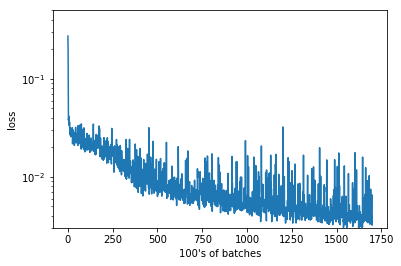

In [15]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('100\'s of batches')
plt.ylabel('loss')
plt.yscale('log')
plt.ylim(0, 0.5) # consistent scale
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 128, 128])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


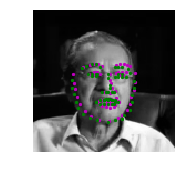

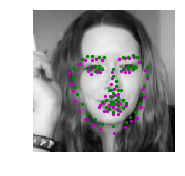

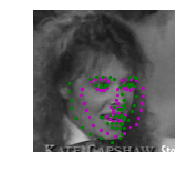

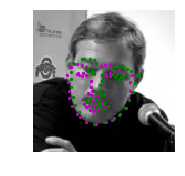

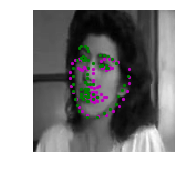

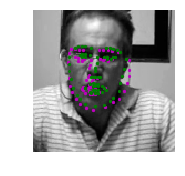

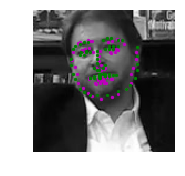

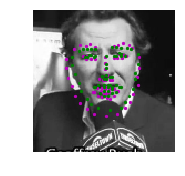

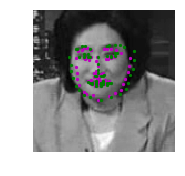

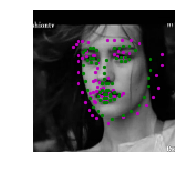

In [17]:
## TODO: visualize your test output
visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I tried using multiple combinations of MSE and SmoothL1Loss loss functions, and SGD and adam optimizers with variety of hyperparameters, batch sizes and initial image sizes. All this was performed on my local GPU. The loss plateaued at ~0.005 with SGD optimizer and SmoothL1Loss after ~20 epochs. The purpose of experimenting with Adam & AdamDelta optimizers was to leverage it's adaptive learning rate in order to further minimize the loss. However, I couldn't seem to reach the same level as SGD in the first place. Then, I tried working with ReduceLROnPlateau scheduler along with SGD. Though, most likely my implementation for the scheduler was incorrect and ultimately created higher order of loss. Finally, I ended with increasing the number of epochs to 50, getting satisfactory results.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: By convention it seemed like a general practice to have multiple convolution layers at the beginning. I started with 2 and then implemented 4 for optimal results in conjuction with SGD optimizer and SmoothL1Loss function. The channel and kernel sizes for the convolution layers along with dropout layers parameters were generally depenedant on trying to not exceed 2GB GPU limit. Dropout layers were added at each step of the model to prevent overfitting.  

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: This was mostly dictated by GPU limits. After 15 epochs the loss decline seemed to have plateaued. So, I trained it till 50 epochs to investigate the decline in further epochs. I also tested batch_size = 5, 10, 20. The GPU was running out of memory beyond 20. Although, this degree of variation in batch_sizes didn't seem to have any noticable impact on the output loss. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.05910381  0.17117648 -0.21080522  0.04890686  0.03102479]
 [-0.24216236 -0.0827845  -0.21216904 -0.05932806 -0.11808277]
 [-0.2875164  -0.24250191  0.12430562  0.05251834  0.22039776]
 [ 0.0565393  -0.06447212  0.13724886 -0.01264255  0.13562258]
 [-0.07188045 -0.06516873  0.10343122  0.18971276  0.16270322]]
(5, 5)


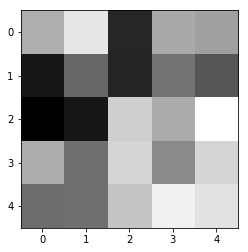

In [19]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.to(torch.device("cpu")).numpy()

filter_index = 5

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

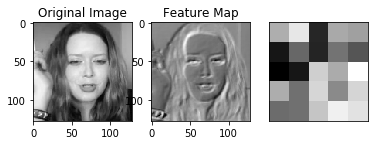

In [31]:
##TODO: load in and display any image from the transformed test dataset
import cv2

sample = test_images[1]
sample = sample.to(torch.device("cpu"))
sample = sample.numpy()   # convert to numpy array from a Tensor
sample = np.transpose(sample, (1, 2, 0))   # transpose to go from torch to numpy image
sample = np.squeeze(sample)

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
filtered = cv2.filter2D(sample, -1, w[filter_index][0])

# Visualization
fig = plt.figure()
ax = fig.add_subplot(131)
plt.imshow(sample, cmap='gray')
ax.set_title("Original Image")

ax = fig.add_subplot(132)
ax.imshow(filtered, cmap = 'gray')
ax.set_title("Feature Map")

ax = fig.add_subplot(133, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')

plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It seems to pick up gradient change in brightness b/w top left and bottom right corners of the image.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!